<a href="https://colab.research.google.com/github/vhrique/anne2024/blob/main/02_Aprendizagem_Supervisionada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pacotes Utilizados nesta Aula

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, load_diabetes
from torch.utils.data import DataLoader, TensorDataset

# Paradigmas de Aprendizagem

Os paradigmas de aprendizagem em redes neurais artificiais (RNAs) são baseados em diferentes maneiras de treinar um modelo e interagir com os dados.
De forma geral, existem três paradigmas principais: aprendizagem supervisionada, aprendizagem não supervisionada e aprendizagem por reforço.
Cada um desses paradigmas possui métodos distintos de treinar modelos, com base na disponibilidade e tipo de dados, bem como no objetivo final da tarefa.

Na aprendizagem supervisionada, o modelo aprende a partir de dados rotulados, tentando prever uma saída correta com base em entradas específicas.

<center><img src="https://github.com/vhrique/anne2024/blob/main/figures/supervised.jpg?raw=true" width="500"></center>

Já na aprendizagem não supervisionada, os dados não possuem rótulos, e o modelo busca identificar padrões ou estruturas nos dados, como clusters ou associações.

<center><img src="https://github.com/vhrique/anne2024/blob/main/figures/clustering.jpg?raw=true" width="500"></center>

Por fim, na aprendizagem por reforço, o modelo aprende através da interação com um ambiente, recebendo recompensas ou penalidades com base nas ações tomadas, ajustando seu comportamento para maximizar a recompensa ao longo do tempo.

<center><img src="https://github.com/vhrique/anne2024/blob/main/figures/reinforcement.jpg?raw=true" width="300"></center>

# Aprendizagem Supervisionada

Entre os paradigmas de aprendizagem mais relevantes está a aprendizagem supervisionada, que será o foco desta aula.

Na aprendizagem supervisionada, o modelo é treinado utilizando um conjunto de dados rotulados, ou seja, para cada entrada, há uma saída esperada conhecida.
O objetivo do modelo é aprender uma função que mapeia as entradas para as saídas corretas, generalizando esse conhecimento para prever novas amostras.
Esse paradigma é amplamente aplicado em tarefas de classificação e regressão.

## Problemas de Classificação

Na classificação, o modelo aprende a categorizar entradas em uma ou mais classes.
Um exemplo clássico é a classificação de imagens de dígitos escritos à mão, onde o modelo deve identificar corretamente o dígito (0 a 9) de uma imagem.
O modelo aprende a identificar padrões que distinguem uma classe de outra.

As três principais categorias de classificação são classificação binária, classificação multiclasse e classificação multilabel. Cada uma tem suas próprias características e desafios.

### Classificação Binária

Na classificação binária, o modelo tem que decidir entre duas classes possíveis.
Por exemplo, um modelo pode classificar e-mails como "spam" ou "não spam". As saídas são representadas por um único valor, geralmente 0 ou 1, onde 0 pode significar "classe negativa" e 1 "classe positiva".
A função de ativação mais comum usada para esse tipo de problema é a sigmoide, que gera uma probabilidade entre 0 e 1.
A função de perda mais utilizada é a Binary Cross-Entropy (BCE).

### Classificação Multiclasse

Na classificação multiclasse, o modelo precisa classificar as entradas em mais de duas classes mutuamente exclusivas.
Um exemplo clássico é a classificação de imagens de dígitos escritos à mão, onde cada dígito (0 a 9) é uma classe diferente.
Nesse caso, o modelo produz uma única saída que corresponde a uma das classes.
A função de ativação comumente usada para multiclasse é a softmax, que normaliza as saídas para que elas somem 1, permitindo a interpretação dessas saídas como probabilidades.
A função de perda mais comum é a Cross-Entropy (entropia cruzada).

### Classificação Multilabel

Na classificação multilabel, cada entrada pode pertencer simultaneamente a várias classes, ou seja, as classes não são mutuamente exclusivas.
Por exemplo, um sistema de recomendação de filmes pode classificar um filme tanto como "comédia" quanto "drama", ou uma imagem pode conter vários objetos diferentes, como "gato", "carro" e "árvore".
Nesse caso, o modelo produz várias saídas, uma para cada possível classe, e cada saída é tratada como um problema de classificação binária (ou seja, uma classe pode estar presente ou não).
Aqui, a sigmoide é usada em cada saída, com a função de perda Binary Cross-Entropy aplicada individualmente para cada classe.

### Exemplo de Classificação

Vejamos um problema de classificação multiclasse simples.
Desta vez, trabalharemos com um dataset famoso, o Iris Dataset de Fisher (1936).

Além disto, agora vamos utilizar validação cruzada para avaliar o modelo. Utilizaremos uma técnica chamada de _Holdout Cross-validation_, que separa os dados de treino e teste de forma aleatória.

Obs: Ainda não estamos levando em consideração um conjunto de validação, onde podemos controlar o treinamento e realizar _early stopping_. Veremos isto no futuro.

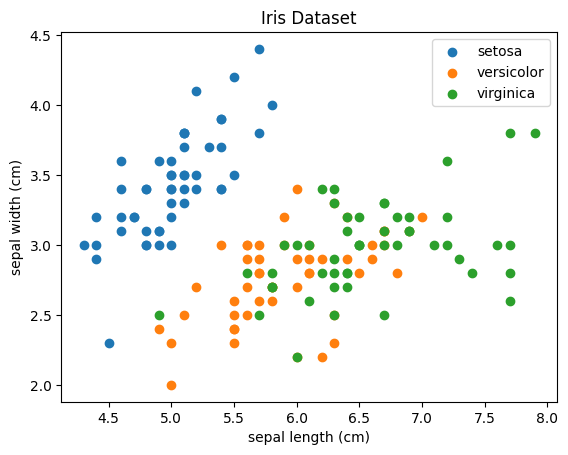

In [138]:
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

for target in np.unique(y):
    plt.scatter(X[y == target,0], X[y == target,1])

plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.legend(iris.target_names)
plt.title('Iris Dataset')
plt.show()

Preparamos o modelo e a rotina de treinamento conforme os materiais da [Aula 01.A: Fundamentos de Pytorch](https://github.com/vhrique/anne2024/blob/main/01a_Fundamentos_de_Pytorch.ipynb).

Porém, modificamos o modelo para ter quatro entradas e três saídas, conforme o problema que iremos resolver, que possui quatro atributos e três classes.

Também utilizaremos outra função de perda, a entropia cruzada categórica.

In [139]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.hidden_layer = torch.nn.Linear(input_size, hidden_size)
        self.output_layer = torch.nn.Linear(hidden_size, 3)

    def forward(self, x):
        x = torch.nn.functional.sigmoid(self.hidden_layer(x))
        return self.output_layer(x)

In [144]:
model = MLP(4, 10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

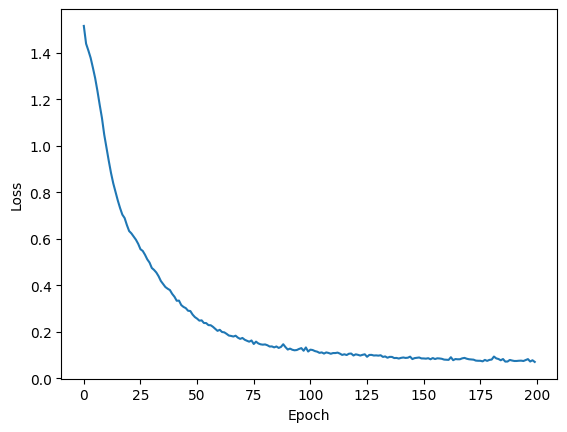

In [145]:
num_epochs = 200
loss_logs = []

for epoch in range(num_epochs):

    # Start epoch loss
    running_loss = 0.0

    for b, (X_batch, y_batch) in enumerate(train_dataloader):

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Update epoch loss
    loss_logs.append(running_loss/b)

# Plot loss
plt.plot(loss_logs)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Finalizado o treino, vamos analisar o resultado.
Abaixo temos métricas de avaliação de classificação mostrando os resultados para o conjunto de treino. Relembrando, ao avaliar o erro no conjunto de treino, estamos realizando ressubstituição. Vemos nisto uma acurácia alta, de 99%. Também conseguimos verificar a precisão (_precision_) e a sensibilidade (_recall_) para cada classe.

In [146]:
with torch.no_grad():
    outputs = model(X_train)

print(
    classification_report(
        y_train.detach().numpy(),
        outputs.detach().numpy().argmax(axis=1),
        target_names=iris.target_names
    )
)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        41
  versicolor       1.00      0.98      0.99        42
   virginica       0.97      1.00      0.99        37

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



Perceba que, ao avaliar a saída, utilizamos o método _argmax_. O objetivo disto é detectar a classe cuja saída possui maior ativação.

Em seguida, realizamos a avaliação da classificação no conjunto de teste, onde temos amostras que o modelo não viu durante o treino. Aqui, vemos uma acurácia mais baixa, de 97%. Esta diferença entre o conjunto de treino e teste é comum, e é um indicativo da capacidade de generalização do modelo. Nosso objetivo final é generalizar. Portanto, buscamos a maior acurácia possível no conjunto de testes.

Caso criemos um modelo muito complexo e treinemos por muito tempo, corremos um grande risco de realizar _overfitting_ no conjunto de treino. Nesta situação, a capacidade preditiva no conjunto de treino é muito alta. Porém, isto vem com um custo de uma capacidade preditiva mais baixa no conjunto de testes.

In [147]:
with torch.no_grad():
    outputs = model(X_test)

print(
    classification_report(
        y_test.detach().numpy(),
        outputs.detach().numpy().argmax(axis=1),
        target_names=iris.target_names
    )
)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00         9
  versicolor       0.89      1.00      0.94         8
   virginica       1.00      0.92      0.96        13

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



## Problemas de Regressão

Na regressão, o objetivo é prever um valor contínuo.
Por exemplo, em problemas de previsão de temperatura, o modelo aprende a mapear uma série de variáveis (como pressão e umidade) para prever a temperatura futura.
Ao contrário da classificação, onde as saídas são discretas, a regressão lida com variáveis contínuas.

Vejamos um exemplo relacionado à detecção de diabetes.

In [129]:
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Vamos aqui adicionar uma nova camada oculta ao modelo, com o objetivo de extrair mais atributos dos sinais de entrada com a rede neural.

In [130]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.hidden_layer1 = torch.nn.Linear(input_size, hidden_size)
        self.hidden_layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.output_layer = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.hidden_layer1(x))
        x = torch.nn.functional.relu(self.hidden_layer2(x))
        return self.output_layer(x)

In [131]:
model = MLP(10, 100)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

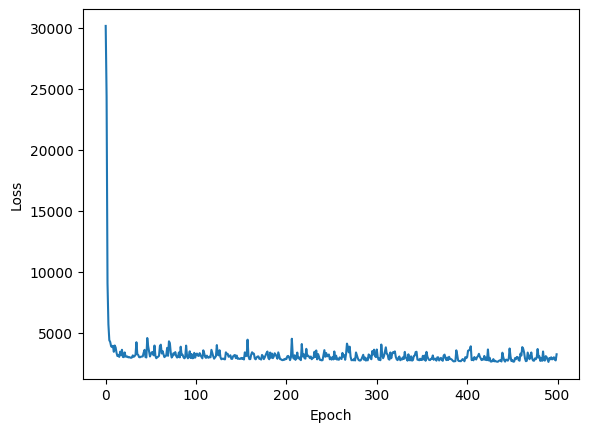

In [132]:
num_epochs = 500
loss_logs = []

for epoch in range(num_epochs):

    # Start epoch loss
    running_loss = 0.0

    for b, (X_batch, y_batch) in enumerate(train_dataloader):

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Update epoch loss
    loss_logs.append(running_loss/b)

# Plot loss
plt.plot(loss_logs)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Após o treino, analisamos o resultado por resubstituição. Neste exemplo, estamos analisando a raiz do erro quadrático médio (_root mean squared error_), uma métrica comum em problemas de regressão.

Também plotamos o gráfico de regressão, que indica qual a previsão do modelo no eixo vertical para os valores esperados no eixo horizontal. Quanto melhor as previsões, mais próximos da linha diagonal preta estarão os pontos azuis das amostras.

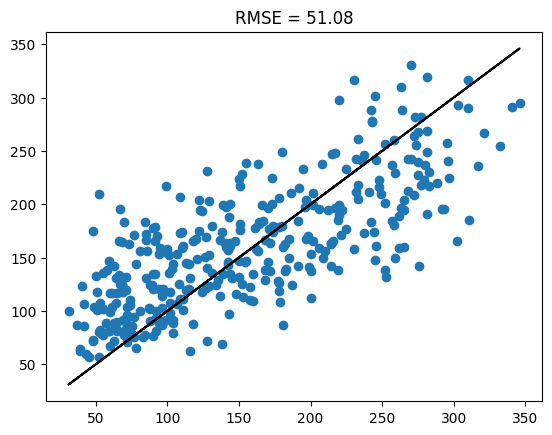

In [136]:
with torch.no_grad():
    outputs = model(X_train)

plt.scatter(y_train, outputs)
plt.plot(y_train, y_train, 'k')
plt.title(f'RMSE = {np.sqrt(criterion(outputs, y_train).item()):.2f}')
plt.show()

Analisamos, por fim, os resultados no conjunto de teste, mostrando um RMSE próximo ao conjunto de treino.

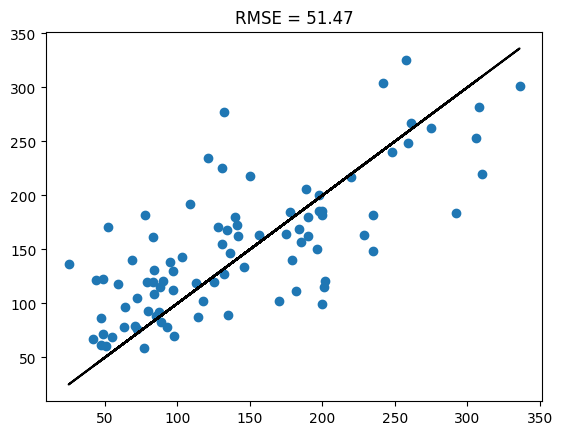

In [137]:
with torch.no_grad():
    outputs = model(X_test)

plt.scatter(y_test, outputs)
plt.plot(y_test, y_test, 'k')
plt.title(f'RMSE = {np.sqrt(criterion(outputs, y_test).item()):.2f}')
plt.show()

# Funções de Perda

As funções de perda (ou funções de custo) são componentes centrais no treinamento de redes neurais, pois medem o quão bem o modelo está performando.
Elas comparam as predições feitas pela rede com os valores reais e retornam um valor numérico que indica o erro da previsão.
O objetivo do treinamento é minimizar essa função de perda ajustando os pesos da rede, com a ajuda de algoritmos de otimização, para que o erro se torne o menor possível.

Essencialmente, a função de perda informa à rede neural como melhorar suas predições ao longo do processo de aprendizado.
Dependendo do tipo de problema (classificação, regressão, multiclasse, etc.), diferentes funções de perda são utilizadas.

## Funções de Perda para Classificação

### Binary Cross-Entropy

A Binary Cross-Entropy (BCE) é comumente usada em problemas de classificação binária, onde o objetivo é prever se uma amostra pertence a uma de duas classes.
Essa função mede a diferença entre a probabilidade prevista e o valor real, penalizando fortemente predições erradas. A fórmula é:

$$
\text{BCE} = - \frac{1}{N}\sum_{i=1}^{N}\left[y_i.log(\hat{y}_i) + (1 - y_i).log(1-\hat{y}_i)\right]
$$

Aqui, $y_i$ é o valor real (0 ou 1) e $\hat{y}_i$ é a probabilidade prevista.
O objetivo é minimizar essa diferença, fazendo com que a probabilidade prevista se aproxime do valor real.

- Vantagem: Funciona muito bem com problemas binários, lidando com probabilidades.
- Desvantagem: Pode ser mais sensível a problemas de balanço de classes.

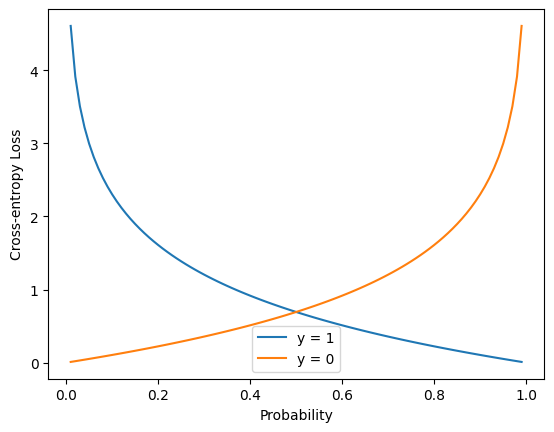

In [173]:
probabilities = np.linspace(0.01,0.99,99)

positive = -np.log(probabilities)
negative = -np.log(1-probabilities)

plt.plot(probabilities, positive)
plt.plot(probabilities, negative)

plt.legend(['y = 1', 'y = 0'])
plt.ylabel('Cross-entropy Loss')
plt.xlabel('Probability')

plt.show()

### Multilabel Binary Cross-Entropy

Em problemas de classificação multilabel, onde uma entrada pode pertencer a mais de uma classe, a Multilabel Binary Cross-Entropy é utilizada.
É basicamente a BCE aplicada a cada rótulo individualmente.
A fórmula é semelhante à da BCE, mas ajustada para várias saídas simultâneas.

- Vantagem: Adequada para problemas onde uma entrada pertence a múltiplas classes.
- Desvantagem: Pode se tornar ineficiente com um grande número de classes.

### Categorical Cross-Entropy

A Entropia Cruzada Categórica é usada em problemas de classificação multiclasse, onde o objetivo é prever uma entre várias classes mutuamente exclusivas.
A fórmula é:

$$
\text{CCE} = - \frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{C}y_{ij}.log(\hat{y}_{ij})
$$

Aqui, $C$ é o número de classes, $y_{ij}$ é o valor real (geralmente um vetor one-hot) e $\hat{y}_{ij}$ é a probabilidade prevista para a classe $j$.
A _softmax_ é usada como função de ativação na saída, convertendo as predições em probabilidades.

- Vantagem: Adequada para problemas com várias classes exclusivas.
- Desvantagem: Não lida bem com situações em que uma instância pode pertencer a múltiplas classes.

### Cross-Entropy como Função de Perda em Redes Neurais

A entropia cruzada (cross-entropy) tem suas origens na teoria da informação, desenvolvida por Claude Shannon na década de 1940.
A ideia central da teoria da informação é quantificar a quantidade de informação ou incerteza presente em um conjunto de dados, e a entropia é uma medida dessa incerteza.
A entropia de Shannon mede o grau de imprevisibilidade de um sistema de eventos, sendo usada para descrever a incerteza associada a uma distribuição de probabilidades.

No contexto de redes neurais, a entropia cruzada é uma medida da divergência entre duas distribuições de probabilidade: a distribuição verdadeira dos rótulos (a saída correta) e a distribuição prevista pelo modelo.
A fórmula original da entropia cruzada é baseada na divergência de Kullback-Leibler (KL Divergence), que mede a diferença entre duas distribuições de probabilidade $P$ e $Q$.
No caso de uma rede neural, $P$ é a distribuição verdadeira dos rótulos (normalmente representada por um vetor one-hot) e $Q$ é a distribuição de probabilidade prevista pelo modelo.

A fórmula da entropia cruzada é dada por:

$$
H(P,Q) = - \sum_{i=1}^{C}P(i).log(Q(i))
$$

Onde:

- $P(i)$ é a probabilidade verdadeira para a classe $i$ (em problemas de classificação, geralmente 0 ou 1).
- $Q(i)$ é a probabilidade prevista pelo modelo para a classe $i$.

A entropia cruzada mede o quão bem o modelo está capturando a distribuição verdadeira dos rótulos.
Quando $P(i)$ é 1 (ou seja, a classe $𝑖$ é a correta), a entropia cruzada penaliza o modelo se a probabilidade $𝑄(i)$ não estiver próxima de 1.

### Margin (Hinge)

O Hinge Loss é usado com máquinas de vetores de suporte (SVMs), mas também pode ser aplicado em redes neurais para problemas de classificação binária.
Ele força o modelo a maximizar a margem entre as classes, penalizando erros de classificação de forma mais agressiva.

A fórmula para um problema binário é:

$$
L = \sum_{i=1}^{N}\text{max}(0,1-y_i.\hat{y}_i)
$$

Aqui, $y_i$ são os rótulos reais (+1 ou -1), $\hat{y}_{i}$ e são as predições do modelo.

- Vantagem: Eficaz em maximizar a separação entre as classes.
- Desvantagem: Principalmente usado em SVMs e menos comum em redes neurais.

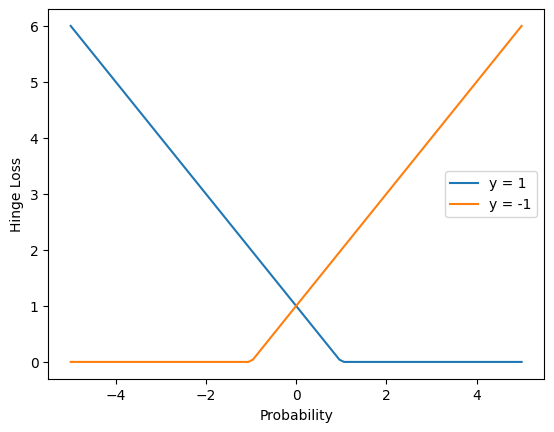

In [187]:
probabilities = np.linspace(-5,5,100)

positive = [max(1-prob, 0) for prob in probabilities]
negative = [max(1+prob, 0) for prob in probabilities]

plt.plot(probabilities, positive)
plt.plot(probabilities, negative)

plt.ylabel('Hinge Loss')
plt.xlabel('Probability')

plt.legend(['y = 1', 'y = -1'])

plt.show()

## Funções de Perda para Regressão

### Mean Squared Error

O MSE é amplamente usado em problemas de regressão, onde o objetivo é prever valores contínuos.
Ele mede a diferença média entre as predições do modelo e os valores reais, elevando ao quadrado essas diferenças para garantir que erros positivos e negativos não se cancelem.
A fórmula é:

$$
\text{MSE} = \frac{1}{N}\sum_{i=1}^N(y_i - \hat{y}_i)^2
$$

onde $y_i$ é o valor real e $\hat{y}_i$ é a predição do modelo.
O quadrado das diferenças garante que erros grandes tenham um impacto maior no valor final.

- Vantagem: Simples de calcular e amplifica grandes erros.
- Desvantagem: Sensível a outliers, já que erros grandes têm um impacto desproporcional.

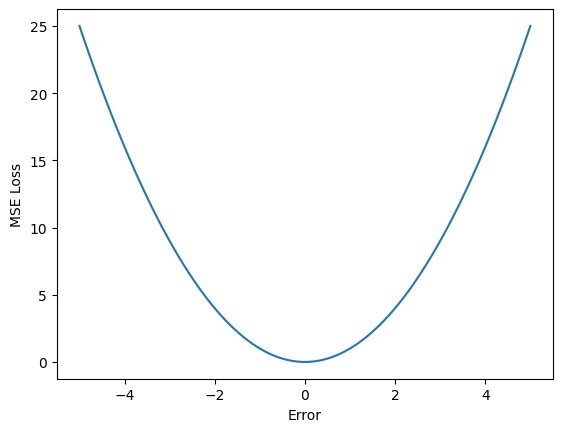

In [175]:
error = np.linspace(-5,5,100)

mse = [e**2 for e in error]

plt.plot(error, mse)

plt.ylabel('MSE Loss')
plt.xlabel('Error')

plt.show()

### Mean Absolute Error

O MAE é outra função de perda usada para problemas de regressão, mas, ao contrário do MSE, mede a diferença absoluta média entre os valores previstos e os valores reais.
Sua fórmula é:

$$
\text{MSE} = \frac{1}{N}\sum_{i=1}^N \left|y_i - \hat{y}_i \right|
$$

- Vantagem: Mais robusto a outliers do que o MSE.
- Desvantagem: Não diferencia grandes e pequenos erros da mesma forma que o MSE.

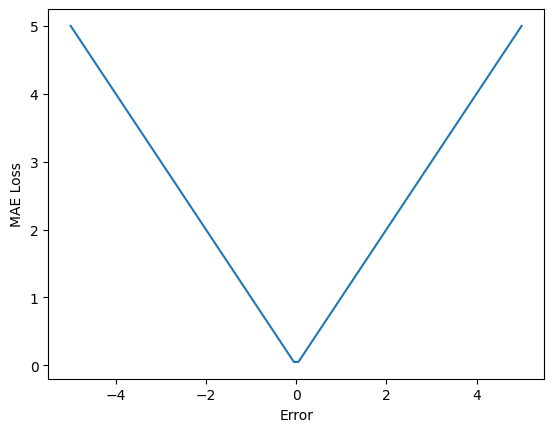

In [177]:
error = np.linspace(-5,5,100)

mse = [abs(e) for e in error]

plt.plot(error, mse)

plt.ylabel('MAE Loss')
plt.xlabel('Error')

plt.show()

### Huber Loss

A Huber Loss é uma função de perda que combina as vantagens do Erro Quadrático Médio (MSE) e do Erro Absoluto Médio (MAE), oferecendo uma abordagem robusta para problemas de regressão, especialmente na presença de outliers.
Ela foi projetada para tratar grandes erros de forma mais eficiente do que o MSE, que é altamente sensível a outliers, enquanto mantém a simplicidade do MAE em regiões de pequenos erros.
A fórmula da Huber Loss é definida de forma diferente para erros pequenos e grandes:

$$
L_{\delta}(y_i, \hat{y}_i) =
\begin{cases}
\frac{1}{2}(y_i - \hat{y}_i)^2 & \text{se } |y_i - \hat{y}_i| \leq \delta \\
\delta \cdot (|y_i - \hat{y}_i| - \frac{1}{2} \delta) & \text{se } |y_i - \hat{y}_i| > \delta
\end{cases}
$$

onde $y_i$ é o valor real, $\hat{y}_i$ é a previsão do modelo e $\delta$ é um parâmetro que define o limite entre erros pequenos e grandes.

A Huber Loss funciona de forma suave em relação a pequenos erros, como o MSE, mas trata erros grandes de maneira mais robusta, como o MAE.
Isso faz com que seja uma função intermediária que lida bem tanto com ruídos pequenos quanto com outliers, sendo especialmente útil em problemas de regressão.

Vantagens:

- Robustez a outliers: Quando há grandes erros ou outliers, a Huber Loss não amplifica esses erros tanto quanto o MSE, evitando que um pequeno número de outliers distorça significativamente o modelo.
- Suavidade em pequenos erros: Para erros pequenos, a Huber Loss se comporta como o MSE, permitindo que a função de perda seja diferenciável e suave, o que facilita a otimização.

Desvantagens:

- Escolha de $\delta$: O valor de
$\delta$ deve ser escolhido cuidadosamente, pois um valor mal ajustado pode levar a um comportamento inadequado da função de perda. Sefor muito pequeno, o modelo se comportará quase como o MAE, e se for muito grande, se aproximará do MSE, perdendo as vantagens da robustez

A Huber Loss é amplamente utilizada em problemas de regressão onde há a presença de outliers nos dados, pois oferece um equilíbrio entre ser suave para erros pequenos e robusta para grandes erros. Além disso, é preferida em aplicações de machine learning onde o MSE tende a ser excessivamente influenciado por grandes outliers.

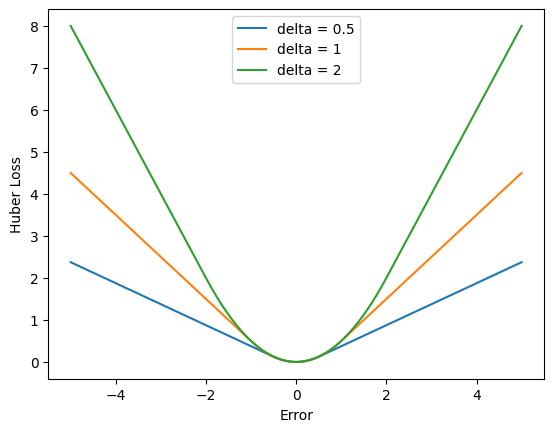

In [186]:
error = np.linspace(-5,5,100)

huber = [[0.5*e**2 if abs(e) <= delta else delta * (abs(e) - 0.5*delta) for e in error] for delta in [0.5, 1, 2]]

for h in huber:
    plt.plot(error, h)

plt.ylabel('Huber Loss')
plt.xlabel('Error')

plt.legend(['delta = 0.5', 'delta = 1', 'delta = 2'])

plt.show()

## Outras Funções de Perda

A KL Divergence é utilizada para medir a diferença entre duas distribuições de probabilidade, sendo particularmente útil em modelos probabilísticos, como variational autoencoders (VAEs).
Ela não é propriamente uma função de perda no sentido tradicional, mas é amplamente usada para regularizar a distribuição de saída de um modelo para que seja similar a uma distribuição-alvo.

A Cosine Similarity Loss mede o ângulo entre dois vetores, sendo usada para comparar a similaridade entre vetores em vez de medir a diferença absoluta.
Isso é especialmente útil em problemas de aprendizado de representações, como em redes neurais siamesas e embedding learning.

A Focal Loss foi introduzida para tratar o problema de desbalanceamento de classes, em que algumas classes são muito mais representadas que outras.
Ela é uma modificação da entropia cruzada que coloca mais peso nas amostras difíceis (ou seja, aquelas que são classificadas de forma incorreta).

Também chamada de Huber Loss, mas com uma implementação ligeiramente diferente, a Smooth L1 Loss é amplamente utilizada em redes neurais para detecção de objetos. Ela é mais robusta a outliers do que a MSE e mais estável do que o MAE.

A Dice Loss é uma função de perda comumente usada em problemas de segmentação de imagens, especialmente em áreas médicas, onde é necessário calcular a sobreposição entre a área predita e a área verdadeira.
É derivada do coeficiente de Dice, que mede a similaridade entre dois conjuntos.

A Triplet Loss é usada para aprendizado de embeddings e aprendizado métrico, particularmente em redes siamesas.
A função de perda incentiva a rede a reduzir a distância entre embeddings de amostras semelhantes (o ancor e o positivo) e aumentar a distância entre o ancor e amostras dissimilares (o negativo).

A Wing Loss é uma função de perda desenhada especificamente para problemas de detecção de landmarks faciais, onde pequenos erros precisam ser suavemente penalizados, mas grandes erros devem ser penalizados de forma mais forte.

# Algoritmos de Otimização

Os algoritmos de otimização são fundamentais para o processo de aprendizagem de redes neurais, pois determinam como os pesos dos neurônios são ajustados para minimizar a função de perda durante o treinamento.
O objetivo da otimização é encontrar os melhores parâmetros (pesos e vieses) que permitam à rede fazer previsões precisas em novos dados.

A função de perda mede o quão longe as previsões do modelo estão dos valores reais, e o papel do algoritmo de otimização é minimizar essa função ajustando gradualmente os pesos.
Isso é feito por meio do cálculo do gradiente, que indica a direção e a magnitude da mudança necessária nos pesos.

Agora, vamos explorar alguns dos principais algoritmos de otimização e suas evoluções:

### Gradiente Descendente

O gradiente descendente é o algoritmo de otimização mais simples e amplamente utilizado.
Ele funciona ajustando os pesos na direção oposta ao gradiente da função de perda com relação a esses pesos.
A ideia é que, ao seguir essa direção de forma iterativa, o algoritmo chegue ao mínimo da função de perda, onde o modelo realiza as previsões mais precisas.

Existem três variações principais do gradiente descendente:

- Batch Gradient Descent: Calcula o gradiente em todo o conjunto de dados de treinamento antes de atualizar os pesos. Esse método pode ser lento e ineficiente para grandes conjuntos de dados.
- Stochastic Gradient Descent (SGD): Atualiza os pesos para cada exemplo de treino individual, tornando o processo mais rápido, mas introduzindo maior variação nas atualizações.
- Mini-Batch Gradient Descent: Combina os dois anteriores, calculando o gradiente em pequenos lotes de dados, acelerando o treinamento e suavizando a variação das atualizações.

### Momentum

O Momentum foi introduzido como uma melhoria ao gradiente descendente.
Ele acelera o processo de convergência em direção ao mínimo, acumulando uma fração do gradiente anterior em cada atualização.
Isso ajuda a suavizar o caminho em direção ao mínimo, evitando oscilações, especialmente em direções que têm gradientes mais ruidosos.

A ideia é que, em vez de seguir estritamente a direção do gradiente atual, o modelo leva em conta o "momento" da direção em que está se movendo, como uma bola rolando por uma superfície irregular.
Isso permite que o modelo alcance o mínimo mais rapidamente.

### RMSProp

O RMSProp é um método de otimização adaptativo que ajusta a taxa de aprendizado individualmente para cada parâmetro, com base na magnitude dos gradientes recentes.
Ele mantém uma média móvel quadrada dos gradientes ao longo do tempo e, ao dividir o gradiente atual por essa média, corrige a taxa de aprendizado para cada parâmetro.
Isso faz com que RMSProp se adapte melhor a problemas com gradientes que variam em escalas diferentes.

Essa adaptação da taxa de aprendizado para cada peso torna o treinamento mais estável e eficaz, especialmente em problemas como redes neurais profundas, onde as atualizações dos pesos podem variar muito.

### ADAM

O ADAM combina o melhor de dois mundos: as ideias do Momentum e do RMSProp.
Ele calcula uma média móvel dos gradientes (como o Momentum) e uma média móvel dos quadrados dos gradientes (como o RMSProp), ajustando a taxa de aprendizado de forma adaptativa para cada parâmetro.

ADAM também inclui uma correção para viés nos primeiros passos, garantindo que as médias móveis comecem corretamente ajustadas.
Esse algoritmo é um dos mais populares atualmente, pois oferece uma convergência mais rápida e estável em diversos tipos de problemas de redes neurais, sendo menos sensível à escolha da taxa de aprendizado inicial.

### Outros Algoritmos

Além dos algoritmos clássicos que discutimos (Gradiente Descendente, Momentum, RMSProp e ADAM), existem outros algoritmos de otimização relevantes que, dependendo do problema e das características da rede neural, podem oferecer vantagens em termos de desempenho ou convergência.

O AdaGrad é um dos primeiros algoritmos de otimização adaptativos, introduzido antes do RMSProp.
Ele ajusta a taxa de aprendizado para cada parâmetro de forma individual, com base nas atualizações anteriores.
Isso significa que parâmetros raramente atualizados têm uma taxa de aprendizado maior, enquanto aqueles que já foram ajustados várias vezes têm a taxa de aprendizado reduzida.
Embora seja útil em problemas esparsos, como no processamento de linguagem natural, onde algumas features são raras, AdaGrad pode sofrer de um decaimento excessivo da taxa de aprendizado, o que leva a convergência mais lenta em muitos casos.

O AdaDelta é uma variação do AdaGrad, projetada para corrigir o problema de decaimento da taxa de aprendizado.
Em vez de acumular todas as atualizações anteriores, como o AdaGrad, o AdaDelta mantém uma janela deslizante de atualizações recentes, limitando o impacto de atualizações passadas muito distantes.
Isso mantém a adaptabilidade da taxa de aprendizado sem que ela diminua drasticamente ao longo do tempo.
Assim como o RMSProp, AdaDelta é muito utilizado em redes profundas e outros problemas complexos.

O Nadam é uma combinação de ADAM com o conceito de Nesterov Momentum.
A diferença em relação ao Momentum clássico é que, no Nesterov Momentum, o cálculo do gradiente é realizado com uma "visão antecipada" da direção para onde os pesos estão se movendo, o que pode acelerar o processo de convergência.
O Nadam aplica essa ideia no contexto do ADAM, resultando em um algoritmo que pode ser ligeiramente mais eficiente e estável do que o ADAM em certos cenários.

O AMSGrad é uma modificação do ADAM que tenta resolver um problema de convergência observada no ADAM original, especialmente em situações onde a função de perda não é convexa.
No ADAM, os parâmetros de aprendizado podem não convergir para o ótimo global em algumas situações.
O AMSGrad corrige isso, garantindo que as médias móveis dos gradientes só decaiam, o que melhora a convergência em alguns problemas.

# Aprendizagem = Representação + Otimização + Avaliação

Conforme indicado por Pedro Domingos (2012), três componentes aparecem em todos os paradigmas de aprendizagem: representação, otimização e avaliação.
Esses três componentes são fundamentais para qualquer paradigma de aprendizagem, desde as tarefas supervisionadas mais simples até as mais complexas formas de aprendizado, como o _self-supervised learning_.
A interação entre esses componentes define o sucesso e a eficácia de um modelo ao generalizar para novos dados e resolver problemas reais.

<center><img src="https://raw.githubusercontent.com/vhrique/anne2024/8eb24ed5fc4d5ffd55d1664b512417ad8a2d71a0/figures/mapa_mental_supervised_learning_reduced.drawio.svg" width="600"></center>

## Representação

A representação refere-se a como os dados e o conhecimento são modelados internamente pelo modelo. Ela define como as características dos dados serão manipuladas para que o modelo possa aprender padrões úteis, e sua escolha tem um impacto significativo no desempenho de um modelo.

## Otimização

O processo de otimização envolve a maneira como o modelo ajusta seus parâmetros internos para minimizar uma função de perda, que mede o quão longe as previsões estão das saídas desejadas. Em redes neurais, esse processo é realizado por algoritmos como o gradiente descendente, que ajusta os pesos das conexões neurais para minimizar a diferença entre a predição do modelo e o rótulo correto, através de técnicas como o backpropagation. Em suma, a otimização busca garantir que o modelo aprenda da melhor maneira possível com os dados disponíveis, ajustando-se para capturar os padrões mais relevantes e reduzir o erro nas predições.

## Avaliação

Por fim, a avaliação mede o quão bem o modelo aprendeu a tarefa. As métricas de avaliação variam conforme a tarefa e o tipo de aprendizado. Na aprendizagem supervisionada, por exemplo, para classificação, utilizamos métricas como acurácia ou F1-score, enquanto, em regressão, utilizamos erro quadrático médio (MSE) ou erro absoluto médio (MAE). Ao treinar redes neurais artificiais, utilizamos funções de perda para guiar o processo de aprendizagem por meio de otimização. Otimização e avaliação, portanto, são componentes complementares e essenciais para garantir que o modelo de aprendizado de máquina aprenda de forma eficiente e seja capaz de realizar boas previsões em novos dados.

## Considerações sobre Representação e Viés Indutivo

Diferentes algoritmos de aprendizado de máquina utilizam diferentes tipos de representação. Por exemplo, o K-Nearest Neighbors (KNN) representa os dados como pontos em um espaço métrico, assumindo que amostras próximas têm comportamentos similares, o que reflete um viés indutivo de proximidade espacial. Já em árvores de decisão, a representação dos dados é estruturada hierarquicamente, onde divisões sucessivas criam nós e folhas que categorizam as amostras, impondo um viés de segmentação binária nos dados.

Nas redes neurais, os dados são representados de forma abstrata através de camadas de neurônios, onde cada camada transforma os dados em representações progressivamente mais complexas e abstratas, refletindo um viés indutivo de que os padrões nos dados podem ser aprendidos através de composições hierárquicas de funções não-lineares. Em uma rede neural profunda, por exemplo, camadas sucessivas de neurônios aprendem representações progressivamente mais complexas dos dados. No início, as camadas podem detectar bordas ou formas simples em uma imagem, enquanto camadas mais profundas podem aprender a identificar objetos ou partes mais complexas.

# Exercícios

1. Aumente o número de neurônios nos exemplos de classificação e regressão e analise a diferença entre os resultados nos conjuntos de treino e teste. O que ocorreu?
2.
3.

# Considerações Finais

## Próxima Aula

# Referências


- Fisher, R. A. (1936). The use of multiple measurements in taxonomic problems. Annals of eugenics, 7(2), 179-188.
- Efron, B., Hastie, T., Johnstone, I., & Tibshirani, R. (2004). Least angle regression.
- Sutskever, I., Martens, J., Dahl, G., & Hinton, G. (2013, May). On the importance of initialization and momentum in deep learning. In International conference on machine learning (pp. 1139-1147). PMLR.
- Shannon, C. E. (1948). A mathematical theory of communication. The Bell system technical journal, 27(3), 379-423.
- Domingos, P. (2012). A few useful things to know about machine learning. Communications of the ACM, 55(10), 78-87.